In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('Data.csv')

scaler = MinMaxScaler(feature_range=(-1, 1))
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [4]:
# Run gpu
device = torch.device('mps')

In [5]:
# Convert data to PyTorch tensors
data_np = data['Close'].values.astype(float)
data_tensor = torch.FloatTensor(data_np).view(-1)

In [6]:
# Define hyperparameters
input_size = 1
hidden_size = 100
num_layers = 2
output_size = 1
learning_rate = 0.001
epochs = 100

In [7]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_stack = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        h_0 = torch.zeros(self.num_layers, input_seq.size(1), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, input_seq.size(1), self.hidden_size).to(device)
        lstm_out, _ = self.lstm_stack(input_seq, (h_0, c_0))
        predictions = self.linear(lstm_out[-1].view(input_seq.size(1), -1))
        return predictions


In [8]:
# Initialize the model, loss function, and optimizer
model = StackedLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Train the model
for epoch in range(epochs):
    for i in range(len(data_tensor) - 1):
        
        # add device gpu to the input and target
        input_seq = data_tensor[i:i+1].view(1, 1, -1).to(device)
        target = data_tensor[i+1:i+2].to(device)

        optimizer.zero_grad()
        y_pred = model(input_seq).to(device)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

/Users/apple/Documents/dev/Pytorch /env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.0008962417487055063
Epoch 10, Loss: 0.0007828137022443116
Epoch 20, Loss: 0.0019972745794802904
Epoch 30, Loss: 0.0018142324406653643
Epoch 40, Loss: 0.001112740719690919
Epoch 50, Loss: 0.0010994551703333855
Epoch 60, Loss: 0.0034923662897199392
Epoch 70, Loss: 0.004088142886757851
Epoch 80, Loss: 0.004401810001581907
Epoch 90, Loss: 0.003851506393402815


In [28]:
future = 100
preds = []
model.eval()
for i in range(len(data_tensor)):
    if i == 0:
        input_seq = data_tensor[i:i+1].view(1, 1, -1)
    else:
        input_seq = torch.FloatTensor(np.array(preds[-1]).cpu()).view(1, 1, -1)

    with torch.no_grad():
        preds.append(model(input_seq))

AttributeError: 'NoneType' object has no attribute 'cpu'

In [24]:
predicted_prices = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

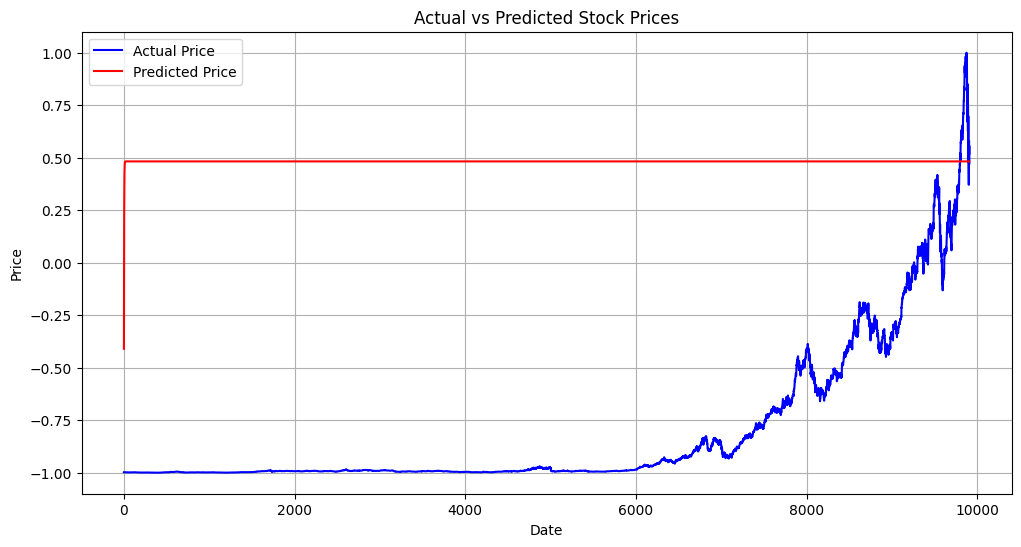

In [25]:
import matplotlib.pyplot as plt

predicted_df = pd.DataFrame(predicted_prices, columns=['Predicted'], index=data.index)

# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Actual Price', color='blue')
plt.plot(predicted_df, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
